In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pydvma as dvma

In [5]:
# Modal sum for velocity transfer function instead of displacement
def modal_sum(w, a_n, z_n, w_n, sigma=0.1, multiclass = False):
    tf = np.zeros_like(w, dtype=np.complex128)
    for i in range(len(a_n)):
        tf += a_n[i] *1j * w / (w_n[i]**2 - w**2 + 1j * 2 * z_n[i] * w * w_n[i])
    noise = np.random.normal(0, sigma, len(w)) + 1j * np.random.normal(0, sigma, len(w))
    tf += noise

    y = np.zeros(len(w))
    for i, w_n_value in enumerate(w_n):
        closest_index = np.argmin(np.abs(w - w_n_value))
        # y[closest_index] = 1
        
        dw = w_n_value * z_n[i] # Half power bandwidth
        indices_in_range = np.where((w > w_n_value - dw) & (w < w_n_value + dw))
        combined_indices = np.concatenate((indices_in_range[0], [closest_index]))

        # if y[combined_indices] == 0:
        #     y[combined_indices] = 1
        # elif y[combined_indices] == 1:
        #     y[combined_indices] = 2
        if multiclass:
            y[combined_indices] = np.where(y[combined_indices] == 0, 1, 2)
        else:
            y[combined_indices] = 1
    return tf, y

In [6]:
def to_db(x):
    if x.shape[-1] == 2:
        return 20 * np.log10(np.linalg.norm(x, axis=-1))
    return 20 * np.log10(np.abs(x))

In [7]:
def split_real_imag(x: np.ndarray) -> np.ndarray:
    return np.column_stack((np.real(x), np.imag(x)))

In [8]:
def generate_data(num_data, num_w_points, multiclass = False):
    X = []
    Y = []
    ws = []
    zs = []
    w = np.linspace(0, 1, num_w_points)
    for i in range(num_data):
        num_modes = np.random.randint(0, 7)
        w_n = np.random.uniform(0, 1, num_modes)
        a_n = np.random.uniform(1, 2, num_modes)
        z_n = np.random.uniform(0.01, 0.20, num_modes)
        sigma = np.random.uniform(0.01, 0.15)
        out, y = modal_sum(w, a_n, z_n, w_n, sigma, multiclass)
        ws.append(w_n)
        zs.append(z_n)
        X.append(split_real_imag(out))
        Y.append(y)
    return np.array(X), np.array(Y), ws, zs

In [9]:
def normalise(x):
    # normalise each example by dividing by the RMS value
    rms = np.sqrt(np.mean(np.linalg.norm(x, axis=-1)**2))
    return x / rms

In [56]:
def plot_tf(tf, y, todb=True, ws = None):
    fig, ax = plt.subplots()
    w = np.linspace(0, 1, len(y))
    if todb:
        ax.plot(w, to_db(tf))
        ax.scatter(w[y == 1], to_db(tf)[y == 1], c='red', marker='o')
        ax.scatter(w[y == 2], to_db(tf)[y == 2], c='orange', marker='o')
    else:
        tf_vals = np.linalg.norm(tf, axis=-1)
        # tf_vals = normalise(tf)
        ax.plot(w, tf_vals)
        ax.scatter(w[y == 1], tf_vals[y == 1], c='red', marker='o')
        ax.scatter(w[y == 2], tf_vals[y == 2], c='orange', marker='o')

    if ws is not None:
        for w_n in ws:
            ax.axvline(w_n, c='black', linestyle='--')
    return fig, ax

In [2]:
X, y, ws, __ = generate_data(2, 500, multiclass=False)
plot_tf(X[0], y[0], ws = ws[0])
print(sorted(ws[0]))

NameError: name 'generate_data' is not defined

In [276]:
# To choose weight of class '2' - result: rougly 20
print(np.count_nonzero(y == 2) / (500 * y.shape[0])) 
print( 1 / (np.count_nonzero(y == 2) / (500 * y.shape[0])))

0.048651
20.554562085054776


In [11]:
def calculate_precision_and_recall(outputs, targets):
    # Convert the outputs to class predictions (index of max value along the last dimension)
    _, predicted = torch.max(outputs, dim=-1)
    
    # Flatten the predictions and targets to 1D tensors
    predicted_flat = predicted.view(-1)
    targets_flat = targets.view(-1)
    
    true_positives = (predicted_flat == targets_flat).sum().item()
    false_positives = ((predicted_flat == 1) & (targets_flat == 0)).sum().item()
    false_negatives = ((predicted_flat == 0) & (targets_flat == 1)).sum().item()
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    
    return precision, recall

In [12]:
def calculate_precision_and_recall_binary(outputs, targets):
    # Round the output to 0 or 1
    predicted = (outputs > 0.5).float()
    true_positives = (predicted * targets).sum().item()
    false_positives = (predicted * (1 - targets)).sum().item()
    false_negatives = ((1 - predicted) * targets).sum().item()
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    return precision, recall

In [13]:
# Multi-class classification
def train_model(model, X, y, valX, valy, name, num_epochs=150):
    X = torch.from_numpy(X).to(torch.float32)
    y = torch.from_numpy(y).to(torch.long)
    val_X = torch.from_numpy(valX).to(torch.float32)
    val_y = torch.from_numpy(valy).to(torch.long)

    dataset = TensorDataset(X, y)
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)

    val_dataset = TensorDataset(val_X, val_y)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,pin_memory=True, num_workers=4)

    # Define a binary cross-entropy loss function and an optimizer
    # pos_weight > 1 aims to increase recall
    # criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([4.0]))  # Binary cross-entropy loss with logits
    # criterion = nn.CrossEntropyLoss(weight = torch.tensor([1.0, 4.0, 20.0]))  
    # criterion = nn.CrossEntropyLoss(weight = torch.tensor([1.0, 4.0, 15.0])) 
    criterion = nn.CrossEntropyLoss(weight = torch.tensor([1.0, 4.0, 8.0])) 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        total_loss = 0.0
        total_precision = 0.0
        total_recall = 0.0
        total_samples = 0

        total_val_precision = 0.0
        total_val_recall = 0.0
        total_val_samples = 0

        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)

            targets = targets.view(-1)
            loss = criterion(outputs.view(-1, 3), targets)
            
            # output = outputs.permute(0, 2, 1)
            # loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            batch_precision, batch_recall = calculate_precision_and_recall(outputs, targets)
            total_loss += loss.item() * len(inputs)
            total_precision += batch_precision * len(inputs)
            total_recall += batch_recall * len(inputs)
            total_samples += len(inputs)

        model.eval() # !!!
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                # outputs = outputs.view(-1, 1)
                # targets = targets.view(-1, 1)
                targets = targets.view(-1)
                batch_precision, batch_recall = calculate_precision_and_recall(outputs, targets)
                total_val_precision += batch_precision * len(inputs)
                total_val_recall += batch_recall * len(inputs)
                total_val_samples += len(inputs)

        average_loss = total_loss / total_samples
        average_precision = total_precision / total_samples
        average_recall = total_recall / total_samples
        # average_accuracy = total_accuracy / total_samples
        average_val_precision = total_val_precision / total_val_samples
        average_val_recall = total_val_recall / total_val_samples

        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}, Accuracy: {average_accuracy}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}, Precision: {average_precision}, Recall: {average_recall}')
        print(f'Validation Precision: {average_val_precision}, Validation Recall: {average_val_recall}')


    torch.save(model, f'{name}.pth')

In [15]:
def train_model_binary(model, X, y, valX, valy, name, num_epochs=150):

    X = torch.from_numpy(X).to(torch.float32)
    y = torch.from_numpy(y).to(torch.float32)
    val_X = torch.from_numpy(valX).to(torch.float32)
    val_y = torch.from_numpy(valy).to(torch.float32)

    dataset = TensorDataset(X, y)
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)

    val_dataset = TensorDataset(val_X, val_y)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Define a binary cross-entropy loss function and an optimizer
    # pos_weight > 1 aims to increase recall
    criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([4.0]))  # Binary cross-entropy loss with logits
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        total_precision = 0.0
        total_recall = 0.0
        total_samples = 0

        total_val_precision = 0.0
        total_val_recall = 0.0
        total_val_samples = 0

        model.train()

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Reshape the outputs and targets for the loss calculation
            outputs = outputs.view(-1, 1)  # Reshape to [batch_size * sequence_length, 1]
            targets = targets.view(-1, 1)
            
            loss = criterion(outputs, targets.float())  # Convert targets to float
            loss.backward()
            optimizer.step()

            batch_precision, batch_recall = calculate_precision_and_recall_binary(outputs, targets)
            total_loss += loss.item() * len(inputs)
            total_precision += batch_precision * len(inputs)
            total_recall += batch_recall * len(inputs)
            total_samples += len(inputs)

        model.eval() # !!!
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                outputs = outputs.view(-1, 1)
                targets = targets.view(-1, 1)

                batch_precision, batch_recall = calculate_precision_and_recall_binary(outputs, targets)
                total_val_precision += batch_precision * len(inputs)
                total_val_recall += batch_recall * len(inputs)
                total_val_samples += len(inputs)

        average_loss = total_loss / total_samples
        average_precision = total_precision / total_samples
        average_recall = total_recall / total_samples
        # average_accuracy = total_accuracy / total_samples
        average_val_precision = total_val_precision / total_val_samples
        average_val_recall = total_val_recall / total_val_samples

        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}, Accuracy: {average_accuracy}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}, Precision: {average_precision}, Recall: {average_recall}')
        print(f'Validation Precision: {average_val_precision}, Validation Recall: {average_val_recall}')


    torch.save(model, f'{name}.pth')

In [16]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        # calls parent class constructor
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.3)
        # hidden_size * 2 because we are using a bidirectional RNN (double the length of the hidden state)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        self.droput = nn.Dropout(0.3)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        # sequence-to-sequence classification problem where you want to classify each time step in the sequence independently.
        out = self.fc(out)
        out = self.droput(out)
        return out

In [17]:
# input size is batch_size, seq_len, input_size (e.g. 1000 x 500 x 2 for 1000 training examples of 500 time steps with 2 features)
# hidden_size is the number of features in the hidden state

input_size = 2
hidden_size = 100
num_layers = 3
num_classes = 3 # multi class classification

In [343]:
X, y, _, __ = generate_data(32*450,200)
valX, valy, _, __ = generate_data(32*100, 200)

In [344]:
multiclass_model = BiLSTM(input_size, hidden_size, num_layers, num_classes)
train_model(multiclass_model, X, y, valX, valy, 'lstm_multiclass_1_50epoch', num_epochs=50)

  2%|▏         | 1/50 [02:35<2:06:54, 155.40s/it]

Epoch [1/50], Loss: 0.45861933668454485, Precision: 0.9400120917285976, Recall: 0.9746733473764435
Validation Precision: 0.937965049711513, Validation Recall: 0.9990439474429796


  4%|▍         | 2/50 [05:08<2:03:19, 154.16s/it]

Epoch [2/50], Loss: 0.3383021424876319, Precision: 0.9704632589081401, Recall: 0.9778759041932785
Validation Precision: 0.9846068494484251, Validation Recall: 0.9894322002899925


  6%|▌         | 3/50 [07:44<2:01:23, 154.98s/it]

Epoch [3/50], Loss: 0.3068346556690004, Precision: 0.9755514946990717, Recall: 0.9786629335392584
Validation Precision: 0.9727303120140476, Validation Recall: 0.9982620199003511


  8%|▊         | 4/50 [10:21<1:59:16, 155.58s/it]

Epoch [4/50], Loss: 0.2898954845137066, Precision: 0.9785763809290196, Recall: 0.9791056880272614
Validation Precision: 0.9773310729739114, Validation Recall: 0.9982609461508248


 10%|█         | 5/50 [12:54<1:55:59, 154.65s/it]

Epoch [5/50], Loss: 0.2753467855850856, Precision: 0.9802023782938238, Recall: 0.9794979206774548
Validation Precision: 0.9805075459469477, Validation Recall: 0.99773288582255


 12%|█▏        | 6/50 [15:26<1:52:48, 153.83s/it]

Epoch [6/50], Loss: 0.26509903613064023, Precision: 0.981277808045249, Recall: 0.9797405574978729
Validation Precision: 0.9910006178954325, Validation Recall: 0.9949757448327357


 14%|█▍        | 7/50 [17:59<1:49:57, 153.44s/it]

Epoch [7/50], Loss: 0.2648305675718519, Precision: 0.9817067852961745, Recall: 0.9795675100724496
Validation Precision: 0.9855288901633739, Validation Recall: 0.9981406423188026


 16%|█▌        | 8/50 [20:33<1:47:44, 153.92s/it]

Epoch [8/50], Loss: 0.2529578728146023, Precision: 0.9830597202185467, Recall: 0.9797419620726954
Validation Precision: 0.9832350087484406, Validation Recall: 0.997768758804157


 18%|█▊        | 9/50 [23:09<1:45:29, 154.37s/it]

Epoch [9/50], Loss: 0.24847273389498392, Precision: 0.9839157275937636, Recall: 0.9799631456982929
Validation Precision: 0.97920741434864, Validation Recall: 0.9986921149327954


 20%|██        | 10/50 [25:42<1:42:34, 153.86s/it]

Epoch [10/50], Loss: 0.2373030329744021, Precision: 0.9850289627910922, Recall: 0.9802786865773565
Validation Precision: 0.9866305185465544, Validation Recall: 0.9982351671266281


 22%|██▏       | 11/50 [28:14<1:39:45, 153.47s/it]

Epoch [11/50], Loss: 0.23651632650030985, Precision: 0.9851670165286908, Recall: 0.980120220385359
Validation Precision: 0.9861712403810787, Validation Recall: 0.9983770848556809


 24%|██▍       | 12/50 [30:49<1:37:32, 154.02s/it]

Epoch [12/50], Loss: 0.22886570307943557, Precision: 0.9863795239857968, Recall: 0.9804022983872344
Validation Precision: 0.9778175573932398, Validation Recall: 0.9985455626455603


 26%|██▌       | 13/50 [33:27<1:35:35, 155.02s/it]

Epoch [13/50], Loss: 0.23061729063590367, Precision: 0.9859100318509159, Recall: 0.980081841555906
Validation Precision: 0.9862458221427436, Validation Recall: 0.9981558893896539


 28%|██▊       | 14/50 [36:04<1:33:24, 155.67s/it]

Epoch [14/50], Loss: 0.22837916019890042, Precision: 0.9862089170437544, Recall: 0.980210372058877
Validation Precision: 0.9902792791763715, Validation Recall: 0.9974901889542497


 30%|███       | 15/50 [38:45<1:31:43, 157.25s/it]

Epoch [15/50], Loss: 0.22838349060879815, Precision: 0.9862233805789855, Recall: 0.9803747006471152
Validation Precision: 0.9876847620498275, Validation Recall: 0.9987745308319707


 32%|███▏      | 16/50 [41:26<1:29:43, 158.33s/it]

Epoch [16/50], Loss: 0.2241140807337231, Precision: 0.9868030859648393, Recall: 0.9803055960259703
Validation Precision: 0.985079670302883, Validation Recall: 0.9990579460532996


 34%|███▍      | 17/50 [44:00<1:26:26, 157.17s/it]

Epoch [17/50], Loss: 0.21715243664052752, Precision: 0.9876438446848596, Recall: 0.980550695424313
Validation Precision: 0.9888152734434503, Validation Recall: 0.9979709878531888


 36%|███▌      | 18/50 [46:34<1:23:18, 156.19s/it]

Epoch [18/50], Loss: 0.21948645694388283, Precision: 0.987351280784383, Recall: 0.9805161721760488
Validation Precision: 0.9899787632231132, Validation Recall: 0.9980793819082723


 38%|███▊      | 19/50 [49:09<1:20:33, 155.92s/it]

Epoch [19/50], Loss: 0.21637603945202297, Precision: 0.9877276504408004, Recall: 0.9804539290090973
Validation Precision: 0.9878068685046031, Validation Recall: 0.9987020641888152


 40%|████      | 20/50 [51:41<1:17:18, 154.61s/it]

Epoch [20/50], Loss: 0.21601830214262008, Precision: 0.9878818383023001, Recall: 0.980419570143462
Validation Precision: 0.9903108118914787, Validation Recall: 0.997770715649597


 42%|████▏     | 21/50 [54:12<1:14:15, 153.65s/it]

Epoch [21/50], Loss: 0.20857703556617102, Precision: 0.9886368217381497, Recall: 0.9806221757190262
Validation Precision: 0.98783431886552, Validation Recall: 0.9986847500452462


 44%|████▍     | 22/50 [56:46<1:11:43, 153.70s/it]

Epoch [22/50], Loss: 0.21335594491826163, Precision: 0.9880641166294201, Recall: 0.980667883029809
Validation Precision: 0.986647252830036, Validation Recall: 0.9985072630623484


 46%|████▌     | 23/50 [59:20<1:09:14, 153.87s/it]

Epoch [23/50], Loss: 0.20651811195744407, Precision: 0.9886022610263615, Recall: 0.9806156766905962
Validation Precision: 0.9901261848857262, Validation Recall: 0.9985334673612175


 48%|████▊     | 24/50 [1:01:57<1:07:00, 154.64s/it]

Epoch [24/50], Loss: 0.20499659369389217, Precision: 0.9889119504666507, Recall: 0.9806394553767299
Validation Precision: 0.9909067308656736, Validation Recall: 0.997189761582323


 50%|█████     | 25/50 [1:04:33<1:04:37, 155.11s/it]

Epoch [25/50], Loss: 0.20588834785752827, Precision: 0.9887309921773699, Recall: 0.9808758455952766
Validation Precision: 0.9891771181338348, Validation Recall: 0.9986196404383015


 52%|█████▏    | 26/50 [1:07:10<1:02:16, 155.67s/it]

Epoch [26/50], Loss: 0.20846418384048673, Precision: 0.9886283402053878, Recall: 0.9805504788827009
Validation Precision: 0.9857573564983453, Validation Recall: 0.999146281756148


 54%|█████▍    | 27/50 [1:09:47<59:47, 155.99s/it]  

Epoch [27/50], Loss: 0.1979685785373052, Precision: 0.9895705296022038, Recall: 0.9807052903084053
Validation Precision: 0.992047936903461, Validation Recall: 0.9980138344388564


 56%|█████▌    | 28/50 [1:12:21<56:59, 155.41s/it]

Epoch [28/50], Loss: 0.21062607056564756, Precision: 0.9880451162323941, Recall: 0.9805023479886299
Validation Precision: 0.990670697373531, Validation Recall: 0.9982473417876585


 58%|█████▊    | 29/50 [1:14:56<54:22, 155.33s/it]

Epoch [29/50], Loss: 0.2006300664279196, Precision: 0.9890821950615202, Recall: 0.9806618996168668
Validation Precision: 0.9871207479342294, Validation Recall: 0.9989474481518776


 60%|██████    | 30/50 [1:17:31<51:43, 155.19s/it]

Epoch [30/50], Loss: 0.2003038469619221, Precision: 0.9895840771733666, Recall: 0.9808631512659799
Validation Precision: 0.9864364653376424, Validation Recall: 0.9990926047625888


 62%|██████▏   | 31/50 [1:20:07<49:15, 155.58s/it]

Epoch [31/50], Loss: 0.1982417494389746, Precision: 0.989569330521137, Recall: 0.9807773669654463
Validation Precision: 0.984900112259063, Validation Recall: 0.9984992925250353


 64%|██████▍   | 32/50 [1:22:43<46:43, 155.76s/it]

Epoch [32/50], Loss: 0.20256165832281112, Precision: 0.989170377469442, Recall: 0.9807330833756929
Validation Precision: 0.9890875386729426, Validation Recall: 0.9985436808962398


 66%|██████▌   | 33/50 [1:25:19<44:04, 155.55s/it]

Epoch [33/50], Loss: 0.19562119864755206, Precision: 0.9899281183534907, Recall: 0.9809213115087193
Validation Precision: 0.989021667753444, Validation Recall: 0.999195314391444


 68%|██████▊   | 34/50 [1:27:53<41:23, 155.20s/it]

Epoch [34/50], Loss: 0.19774604363573922, Precision: 0.9894092024682059, Recall: 0.980674928062402
Validation Precision: 0.9914978429756266, Validation Recall: 0.9982046391095551


 70%|███████   | 35/50 [1:30:27<38:42, 154.86s/it]

Epoch [35/50], Loss: 0.19342681994040808, Precision: 0.9899586660468116, Recall: 0.9809341755589586
Validation Precision: 0.9862546717588002, Validation Recall: 0.9991762960046873


 72%|███████▏  | 36/50 [1:33:01<36:05, 154.65s/it]

Epoch [36/50], Loss: 0.19054510093397564, Precision: 0.9902050646677057, Recall: 0.9809045963987624
Validation Precision: 0.9866922059073967, Validation Recall: 0.9989424599264163


 74%|███████▍  | 37/50 [1:35:34<33:24, 154.21s/it]

Epoch [37/50], Loss: 0.18907088021437327, Precision: 0.9905720477078187, Recall: 0.9808982411002131
Validation Precision: 0.987217048273129, Validation Recall: 0.9993289718321359


 76%|███████▌  | 38/50 [1:38:08<30:50, 154.17s/it]

Epoch [38/50], Loss: 0.19504796117544174, Precision: 0.9899884289594995, Recall: 0.9807562516764439
Validation Precision: 0.9914271123051286, Validation Recall: 0.99865966481683


 78%|███████▊  | 39/50 [1:40:41<28:09, 153.58s/it]

Epoch [39/50], Loss: 0.18895505100488663, Precision: 0.9904638447764639, Recall: 0.9809821473127196
Validation Precision: 0.9881405281408852, Validation Recall: 0.9989961458247418


 80%|████████  | 40/50 [1:43:13<25:32, 153.22s/it]

Epoch [40/50], Loss: 0.19423117803202736, Precision: 0.9899449114570333, Recall: 0.9808206290191688
Validation Precision: 0.9889708571492585, Validation Recall: 0.9989373189800334


 82%|████████▏ | 41/50 [1:45:46<22:58, 153.16s/it]

Epoch [41/50], Loss: 0.1958515194389555, Precision: 0.9900100410445453, Recall: 0.9808190395270311
Validation Precision: 0.9855882744203532, Validation Recall: 0.9986194275315854


 84%|████████▍ | 42/50 [1:48:19<20:25, 153.23s/it]

Epoch [42/50], Loss: 0.18822486029730903, Precision: 0.9906483706953008, Recall: 0.9810559651890273
Validation Precision: 0.9905988764795329, Validation Recall: 0.9989928535266175


 86%|████████▌ | 43/50 [1:50:53<17:52, 153.20s/it]

Epoch [43/50], Loss: 0.18375347385803859, Precision: 0.9909752661873555, Recall: 0.9809241206723383
Validation Precision: 0.9905491804453425, Validation Recall: 0.9981690986416537


 88%|████████▊ | 44/50 [1:53:26<15:19, 153.19s/it]

Epoch [44/50], Loss: 0.1900697429643737, Precision: 0.9900837606680395, Recall: 0.9807746468478679
Validation Precision: 0.9906410360684904, Validation Recall: 0.9983107786344324


 90%|█████████ | 45/50 [1:55:59<12:45, 153.10s/it]

Epoch [45/50], Loss: 0.18812751478619047, Precision: 0.9904538907356023, Recall: 0.980907447558925
Validation Precision: 0.9892649561230581, Validation Recall: 0.9992327390344208


 92%|█████████▏| 46/50 [1:58:31<10:12, 153.03s/it]

Epoch [46/50], Loss: 0.18128859453731114, Precision: 0.991293738574129, Recall: 0.9810501611097251
Validation Precision: 0.9885610699124103, Validation Recall: 0.9990339561634038


 94%|█████████▍| 47/50 [2:01:06<07:40, 153.62s/it]

Epoch [47/50], Loss: 0.1876218392782741, Precision: 0.9906476198370715, Recall: 0.981005492339656
Validation Precision: 0.9906328295055851, Validation Recall: 0.9989703130560379


 96%|█████████▌| 48/50 [2:03:43<05:09, 154.64s/it]

Epoch [48/50], Loss: 0.18601325571537017, Precision: 0.9908083101968465, Recall: 0.9809980344785001
Validation Precision: 0.9926094879900111, Validation Recall: 0.9988171535146801


 98%|█████████▊| 49/50 [2:06:17<02:34, 154.36s/it]

Epoch [49/50], Loss: 0.1811784518427319, Precision: 0.9913050506874301, Recall: 0.9810371116910777
Validation Precision: 0.9921839858036781, Validation Recall: 0.9983994535349371


100%|██████████| 50/50 [2:08:51<00:00, 154.63s/it]

Epoch [50/50], Loss: 0.1855898708436224, Precision: 0.9910834211550483, Recall: 0.9810522154748278
Validation Precision: 0.9890085804492372, Validation Recall: 0.9992221042994578


In [18]:
def plot_predictions(val_inputs, val_outputs, val_targets, multiclass=False):

    fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize=(12,12))
    w = np.linspace(0, 1, len(val_targets[0]))
    for index, ax in enumerate(axs.flat):

        targets = np.array(val_targets[index].numpy())
        test_op = np.array(val_outputs[index].numpy())

        if multiclass:
            predicted = np.argmax(test_op, axis=-1)
            ax.plot(w, to_db(val_inputs[index].numpy()))

            for i in range(len(w)):
                if predicted[i] == 1:
                    ax.scatter(w[i], to_db(val_inputs[index].numpy())[i], c='red', marker='o')
                if predicted[i] == 2:
                    ax.scatter(w[i], to_db(val_inputs[index].numpy())[i], c='orange', marker='o')
                if targets[i] == 1:
                    ax.scatter(w[i], 0, c='green', marker='o')
                if targets[i] == 2:
                    ax.scatter(w[i], 0, c='blue', marker='o')

        else:
            predicted = (test_op > 0.0).astype(int)
            ax.plot(w, to_db(val_inputs[index].numpy()))

            for i in range(len(w)):
                if predicted[i] == 1:
                    ax.scatter(w[i], to_db(val_inputs[index].numpy())[i], c='red', marker='o')
                if targets[i] == 1:
                    ax.scatter(w[i], 0, c='green', marker='o')

    plt.tight_layout()

In [19]:
def validate_model(model, norm = False, multiclass = False):
    valX, valy, _, __ = generate_data(32*1, 200, multiclass=multiclass)
    val_X = torch.from_numpy(valX).to(torch.float32)
    if multiclass:
        val_y = torch.from_numpy(valy).to(torch.long)
    else:
        val_y = torch.from_numpy(valy).to(torch.float32)

    if norm:
        val_X = normalise(val_X)
    dataset = TensorDataset(val_X, val_y)
    val_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    model.eval()
    for val_inputs, val_targets in val_loader:
        with torch.no_grad():
            val_outputs = model(val_inputs)

    plot_predictions(val_inputs, val_outputs, val_targets, multiclass=multiclass)

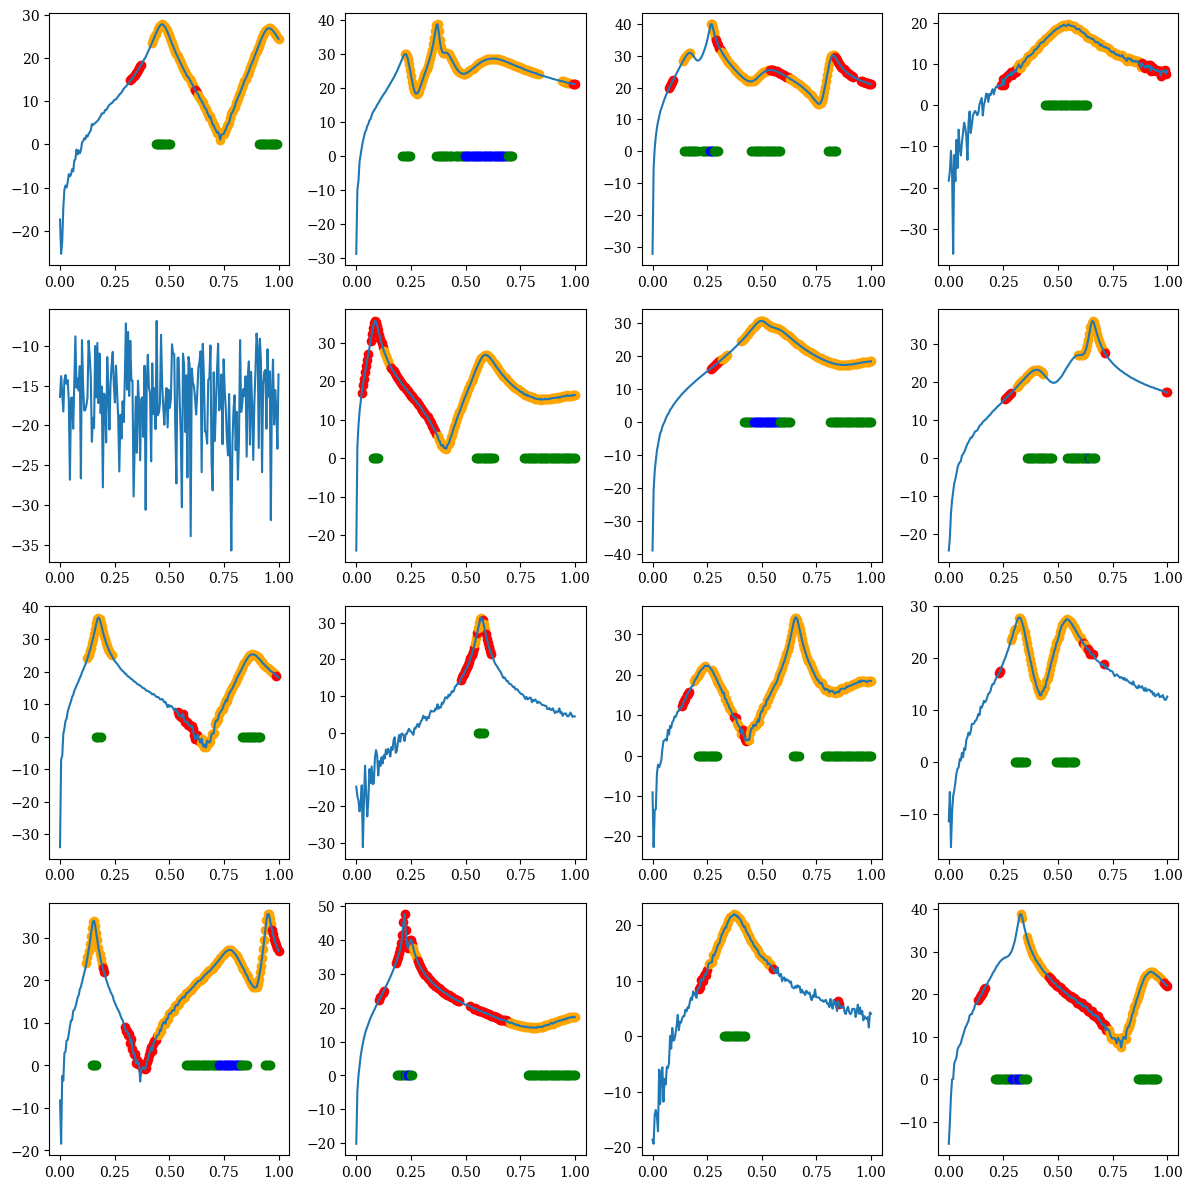

In [374]:
validate_model(multiclass_model)

Normalise by rms signal value before inputting to model (supposed to preserve phase info also)

In [345]:
X, y, _, __ = generate_data(32*450,200)
valX, valy, _, __ = generate_data(32*100, 200)

X = normalise(X)
valX = normalise(valX)

multiclass_model_norm = BiLSTM(input_size, hidden_size, num_layers, num_classes)
train_model(multiclass_model, X, y, valX, valy, 'lstm_multiclass_normalise_50epoch', num_epochs=50)

  2%|▏         | 1/50 [02:30<2:02:41, 150.23s/it]

Epoch [1/50], Loss: 0.6154921699894799, Precision: 0.9393803776738376, Recall: 0.9692725294425947
Validation Precision: 0.978531090911693, Validation Recall: 0.9967324780862451


  4%|▍         | 2/50 [05:00<2:00:02, 150.05s/it]

Epoch [2/50], Loss: 0.3096700546476576, Precision: 0.9752037640300326, Recall: 0.9784589066271671
Validation Precision: 0.9635744619220508, Validation Recall: 0.9989911551323086


  6%|▌         | 3/50 [07:32<1:58:20, 151.08s/it]

Epoch [3/50], Loss: 0.27523084514670904, Precision: 0.9799661233954442, Recall: 0.9792590683264066
Validation Precision: 0.9810389562371021, Validation Recall: 0.9971919494972491


  8%|▊         | 4/50 [10:04<1:56:05, 151.43s/it]

Epoch [4/50], Loss: 0.2531617634495099, Precision: 0.9827473638406742, Recall: 0.979499542508759
Validation Precision: 0.9844506759837733, Validation Recall: 0.9988525328502379


 10%|█         | 5/50 [12:35<1:53:31, 151.36s/it]

Epoch [5/50], Loss: 0.24270237690872618, Precision: 0.9844317129201888, Recall: 0.9800146190558412
Validation Precision: 0.9886495215811739, Validation Recall: 0.9981923930087688


 12%|█▏        | 6/50 [15:07<1:50:59, 151.36s/it]

Epoch [6/50], Loss: 0.23940424548255074, Precision: 0.9849881072931198, Recall: 0.9800031072454934
Validation Precision: 0.9837849679645464, Validation Recall: 0.9991420633115213


 14%|█▍        | 7/50 [17:38<1:48:30, 151.41s/it]

Epoch [7/50], Loss: 0.23550875627332263, Precision: 0.9854176752048125, Recall: 0.9802805323953695
Validation Precision: 0.9850083915845961, Validation Recall: 0.9993875748599135


 16%|█▌        | 8/50 [20:08<1:45:43, 151.04s/it]

Epoch [8/50], Loss: 0.21517998920546638, Precision: 0.98772619578327, Recall: 0.9805498362969925
Validation Precision: 0.9877135607699371, Validation Recall: 0.9990862349647277


 18%|█▊        | 9/50 [22:39<1:43:09, 150.96s/it]

Epoch [9/50], Loss: 0.22164118332995308, Precision: 0.9872774374310763, Recall: 0.980320860730119
Validation Precision: 0.9905791077092948, Validation Recall: 0.9980664888913584


 20%|██        | 10/50 [25:10<1:40:33, 150.84s/it]

Epoch [10/50], Loss: 0.21200310667355857, Precision: 0.9883154471244516, Recall: 0.9806009732566633
Validation Precision: 0.9852236362230355, Validation Recall: 0.9992358664434948


 22%|██▏       | 11/50 [27:40<1:37:59, 150.75s/it]

Epoch [11/50], Loss: 0.2179371553659439, Precision: 0.9878285067820043, Recall: 0.9803667968716346
Validation Precision: 0.9864811256966253, Validation Recall: 0.9990881430169167


 24%|██▍       | 12/50 [30:07<1:34:43, 149.57s/it]

Epoch [12/50], Loss: 0.20848701857858234, Precision: 0.9889326851707593, Recall: 0.9806412987583757
Validation Precision: 0.9912659787132242, Validation Recall: 0.99916069953326


 26%|██▌       | 13/50 [32:32<1:31:20, 148.13s/it]

Epoch [13/50], Loss: 0.2094414183497429, Precision: 0.9891204731959575, Recall: 0.9806756157245821
Validation Precision: 0.9898747262414501, Validation Recall: 0.9986443675460898


 28%|██▊       | 14/50 [34:57<1:28:19, 147.20s/it]

Epoch [14/50], Loss: 0.20579527576764425, Precision: 0.9892801587200063, Recall: 0.9807405561379983
Validation Precision: 0.9899451857863353, Validation Recall: 0.9983990728247473


 30%|███       | 15/50 [37:23<1:25:45, 147.00s/it]

Epoch [15/50], Loss: 0.2037642780277464, Precision: 0.9892773151868967, Recall: 0.9808204563107266
Validation Precision: 0.9924652998861074, Validation Recall: 0.9982201828803082


 32%|███▏      | 16/50 [39:51<1:23:24, 147.20s/it]

Epoch [16/50], Loss: 0.20088276777002548, Precision: 0.9898647733991361, Recall: 0.980790209496331
Validation Precision: 0.987857046301402, Validation Recall: 0.9992178466180707


 34%|███▍      | 17/50 [42:21<1:21:27, 148.11s/it]

Epoch [17/50], Loss: 0.20266259653700722, Precision: 0.9893764883768056, Recall: 0.9806641293167789
Validation Precision: 0.9860047313184505, Validation Recall: 0.9994694916266817


 36%|███▌      | 18/50 [44:50<1:19:08, 148.40s/it]

Epoch [18/50], Loss: 0.19921469893720414, Precision: 0.9902083534645709, Recall: 0.9809055773091225
Validation Precision: 0.9894477713508297, Validation Recall: 0.9993237358594439


 38%|███▊      | 19/50 [47:22<1:17:10, 149.37s/it]

Epoch [19/50], Loss: 0.19372450159655677, Precision: 0.990638962432162, Recall: 0.9809662680103906
Validation Precision: 0.9858667681149417, Validation Recall: 0.9993321863065704


 40%|████      | 20/50 [49:52<1:14:49, 149.66s/it]

Epoch [20/50], Loss: 0.19586681418948704, Precision: 0.9905020874550823, Recall: 0.9810969964793186
Validation Precision: 0.9900012529090977, Validation Recall: 0.9991230923502005


 42%|████▏     | 21/50 [52:23<1:12:32, 150.08s/it]

Epoch [21/50], Loss: 0.18907847189240987, Precision: 0.9909611272939473, Recall: 0.9808431858410361
Validation Precision: 0.990118317857422, Validation Recall: 0.9994015509609087


 44%|████▍     | 22/50 [54:54<1:10:02, 150.09s/it]

Epoch [22/50], Loss: 0.19034870511955684, Precision: 0.9908471372997961, Recall: 0.9808548602418246
Validation Precision: 0.990250612704839, Validation Recall: 0.9993750661555498


 46%|████▌     | 23/50 [57:24<1:07:33, 150.15s/it]

Epoch [23/50], Loss: 0.1942248139778773, Precision: 0.9904372595231523, Recall: 0.9807746272474938
Validation Precision: 0.9899539722303676, Validation Recall: 0.9992590023039132


 48%|████▊     | 24/50 [59:54<1:05:05, 150.21s/it]

Epoch [24/50], Loss: 0.1829561166630851, Precision: 0.9915654748021981, Recall: 0.9810178765776063
Validation Precision: 0.9870410083533362, Validation Recall: 0.9988525489678703


 50%|█████     | 25/50 [1:02:24<1:02:35, 150.22s/it]

Epoch [25/50], Loss: 0.1935780232813623, Precision: 0.9905834633562257, Recall: 0.9809227987263884
Validation Precision: 0.9917575100280367, Validation Recall: 0.998663991216076


 52%|█████▏    | 26/50 [1:04:55<1:00:06, 150.26s/it]

Epoch [26/50], Loss: 0.18821615384684667, Precision: 0.9910900003133132, Recall: 0.9809772278229807
Validation Precision: 0.9911540196974804, Validation Recall: 0.9991668935627532


 54%|█████▍    | 27/50 [1:07:27<57:46, 150.70s/it]  

Epoch [27/50], Loss: 0.18536552727222444, Precision: 0.9912482111095016, Recall: 0.9809766646745299
Validation Precision: 0.9929219799409843, Validation Recall: 0.9979104544481351


 56%|█████▌    | 28/50 [1:09:56<55:09, 150.43s/it]

Epoch [28/50], Loss: 0.18659725271993213, Precision: 0.9910876618544258, Recall: 0.9810457421854711
Validation Precision: 0.9888709007052185, Validation Recall: 0.9996304920060924


 58%|█████▊    | 29/50 [1:12:27<52:37, 150.37s/it]

Epoch [29/50], Loss: 0.18377715369065603, Precision: 0.9914146401672222, Recall: 0.9809847471234369
Validation Precision: 0.9896105229824527, Validation Recall: 0.9994186608343522


 60%|██████    | 30/50 [1:14:57<50:07, 150.37s/it]

Epoch [30/50], Loss: 0.1816855987906456, Precision: 0.9916613177885436, Recall: 0.98104892184297
Validation Precision: 0.9895917478268017, Validation Recall: 0.999534518916869


 62%|██████▏   | 31/50 [1:17:30<47:50, 151.09s/it]

Epoch [31/50], Loss: 0.17899577193790012, Precision: 0.9917874234613225, Recall: 0.9809550311563944
Validation Precision: 0.9868677845693078, Validation Recall: 0.9992885201742746


 64%|██████▍   | 32/50 [1:20:01<45:23, 151.30s/it]

Epoch [32/50], Loss: 0.17807046092218823, Precision: 0.991903553752245, Recall: 0.9811282296088074
Validation Precision: 0.9919661956776473, Validation Recall: 0.9988171851370974


 66%|██████▌   | 33/50 [1:22:32<42:49, 151.15s/it]

Epoch [33/50], Loss: 0.1914528164598677, Precision: 0.9906581486246595, Recall: 0.9808246681383308
Validation Precision: 0.989823964701976, Validation Recall: 0.9987786345439766


 68%|██████▊   | 34/50 [1:25:02<40:12, 150.75s/it]

Epoch [34/50], Loss: 0.1767748541964425, Precision: 0.9921796569885124, Recall: 0.9810215005808084
Validation Precision: 0.9885796287832627, Validation Recall: 0.9995688215099133


 70%|███████   | 35/50 [1:27:30<37:29, 149.94s/it]

Epoch [35/50], Loss: 0.17856897165377936, Precision: 0.9919745288136006, Recall: 0.9809917356391823
Validation Precision: 0.9927845919157516, Validation Recall: 0.9986022914930398


 72%|███████▏  | 36/50 [1:29:57<34:44, 148.87s/it]

Epoch [36/50], Loss: 0.1786914020445612, Precision: 0.9919792389221512, Recall: 0.9810462654233392
Validation Precision: 0.9915119995081656, Validation Recall: 0.9993320820983618


 74%|███████▍  | 37/50 [1:32:23<32:06, 148.18s/it]

Epoch [37/50], Loss: 0.18192193888955646, Precision: 0.9917449214239674, Recall: 0.9810103968971554
Validation Precision: 0.9902746846395342, Validation Recall: 0.9992899837371892


 76%|███████▌  | 38/50 [1:34:49<29:31, 147.59s/it]

Epoch [38/50], Loss: 0.17506522837612365, Precision: 0.992486813318063, Recall: 0.9812055120121829
Validation Precision: 0.9895353627995255, Validation Recall: 0.9993413918409065


 78%|███████▊  | 39/50 [1:37:15<26:56, 147.00s/it]

Epoch [39/50], Loss: 0.17570597532722684, Precision: 0.9923511734833664, Recall: 0.9811728926324864
Validation Precision: 0.9911719140963742, Validation Recall: 0.9994346473554326


 80%|████████  | 40/50 [1:39:41<24:26, 146.63s/it]

Epoch [40/50], Loss: 0.1774443511168162, Precision: 0.9923243358348117, Recall: 0.9811178202568744
Validation Precision: 0.9908016109465164, Validation Recall: 0.9995521453916321


 82%|████████▏ | 41/50 [1:42:07<21:58, 146.50s/it]

Epoch [41/50], Loss: 0.177006164987882, Precision: 0.9921651844505922, Recall: 0.9811297542237563
Validation Precision: 0.993437646759346, Validation Recall: 0.9986796700315217


 84%|████████▍ | 42/50 [1:44:33<19:30, 146.31s/it]

Epoch [42/50], Loss: 0.16882440368334453, Precision: 0.9929440231322229, Recall: 0.9812590747989814
Validation Precision: 0.9927121564181669, Validation Recall: 0.9991632072372632


 86%|████████▌ | 43/50 [1:47:05<17:15, 147.95s/it]

Epoch [43/50], Loss: 0.17552937421533796, Precision: 0.992393369298569, Recall: 0.9812073252816664
Validation Precision: 0.9929630459557849, Validation Recall: 0.9992132555242307


 88%|████████▊ | 44/50 [1:49:37<14:55, 149.32s/it]

Epoch [44/50], Loss: 0.17438583814435535, Precision: 0.9924787501665505, Recall: 0.9811594680547905
Validation Precision: 0.9923078907922676, Validation Recall: 0.9990328224711227


 90%|█████████ | 45/50 [1:52:09<12:30, 150.01s/it]

Epoch [45/50], Loss: 0.17895316908756892, Precision: 0.9922446805665105, Recall: 0.9811691801705342
Validation Precision: 0.9881988253546736, Validation Recall: 0.9994316682121758


 92%|█████████▏| 46/50 [1:54:39<10:00, 150.16s/it]

Epoch [46/50], Loss: 0.17640889449252023, Precision: 0.9921394309048044, Recall: 0.9811443725780423
Validation Precision: 0.9922044995223481, Validation Recall: 0.9980491512290096


 94%|█████████▍| 47/50 [1:57:09<07:30, 150.12s/it]

Epoch [47/50], Loss: 0.16707826809750662, Precision: 0.9930652381504623, Recall: 0.9812993295160293
Validation Precision: 0.9932161888509793, Validation Recall: 0.9991993387326127


 96%|█████████▌| 48/50 [1:59:41<05:01, 150.56s/it]

Epoch [48/50], Loss: 0.17122300098339716, Precision: 0.9930123937921528, Recall: 0.9813405339081452
Validation Precision: 0.9892472312091845, Validation Recall: 0.999664588113619


 98%|█████████▊| 49/50 [2:02:11<02:30, 150.59s/it]

Epoch [49/50], Loss: 0.17002133670780395, Precision: 0.992975006687267, Recall: 0.9813227369681734
Validation Precision: 0.9941037671874611, Validation Recall: 0.9989383390921733


100%|██████████| 50/50 [2:04:42<00:00, 149.66s/it]

Epoch [50/50], Loss: 0.16291509320338568, Precision: 0.9933623638037232, Recall: 0.9813232277751807
Validation Precision: 0.9924998548222668, Validation Recall: 0.9993481734871363


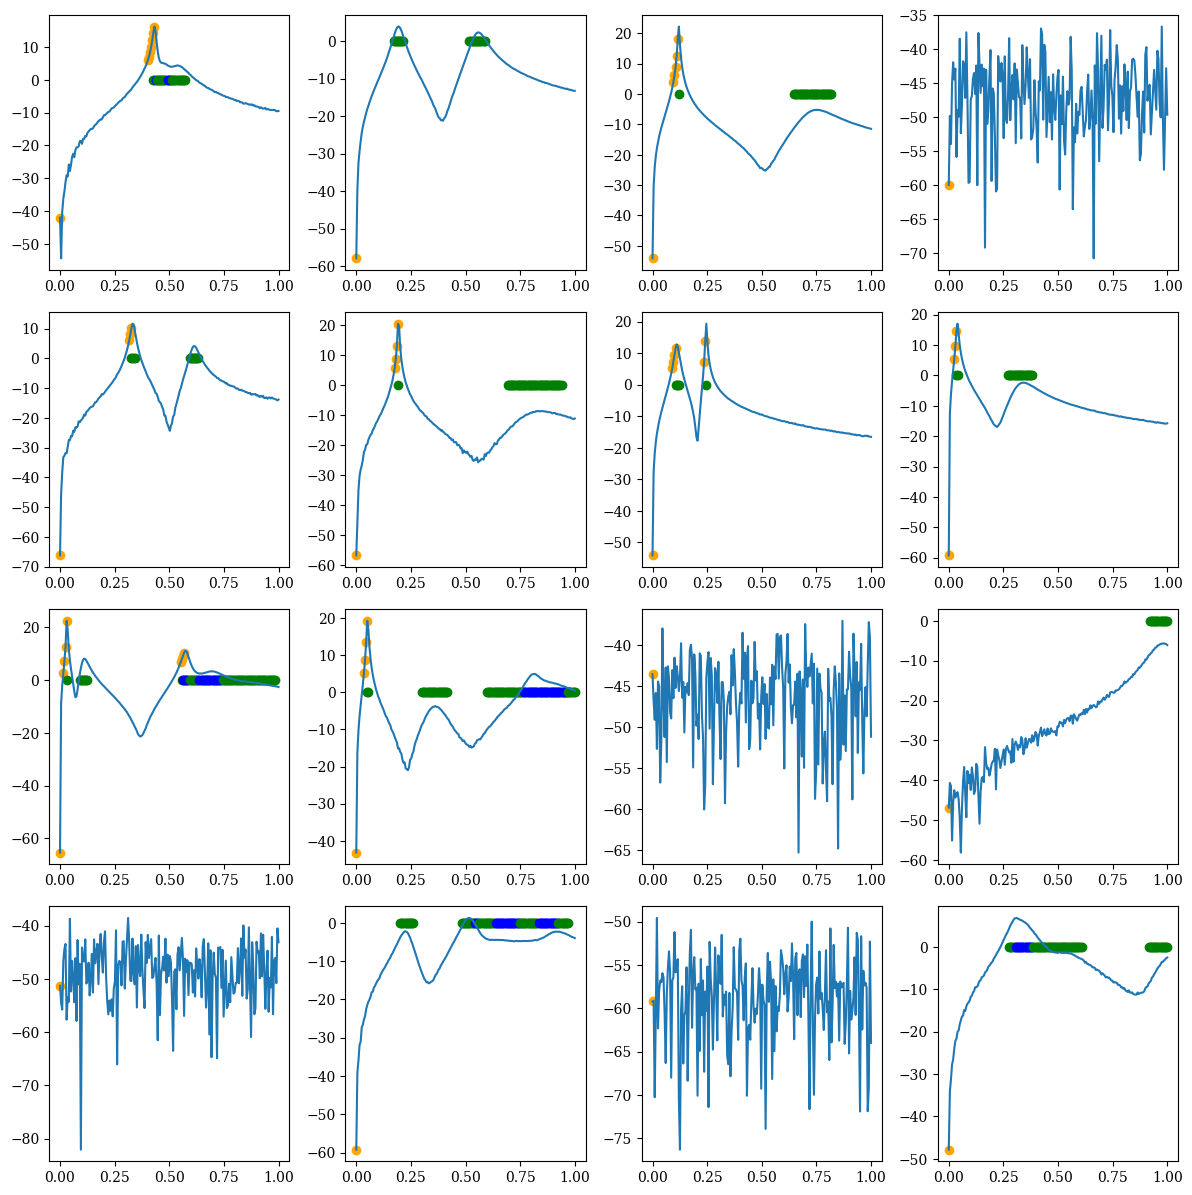

In [375]:
validate_model(multiclass_model_norm, norm=True)

In [371]:
d = dvma.load_data()
tf_data = d.tf_data_list[0]
tf_arr = np.array(tf_data.tf_data)
print(tf_arr.shape)

2023-11-13 10:14:36.748 python[13509:878232] +[CATransaction synchronize] called within transaction


(8183, 1)


[2 0 0 ... 0 0 0]
22


(<Figure size 640x480 with 1 Axes>, <Axes: >)

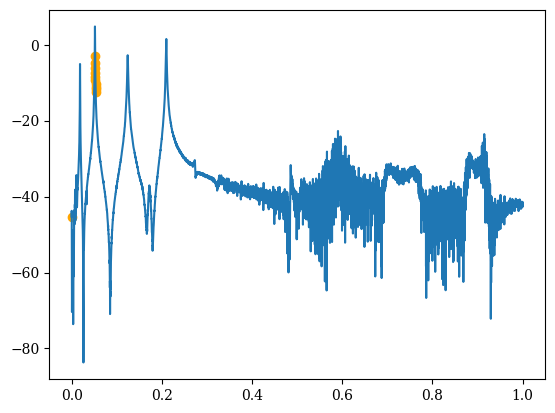

In [384]:
lab_tf = split_real_imag(tf_arr).reshape(1, -1, 2)
lab_tf_norm = normalise(lab_tf)
lab_tf_tensor = torch.from_numpy(lab_tf_norm).to(torch.float32)

multiclass_model_norm.eval()
with torch.no_grad():
    lab_tf_output = multiclass_model_norm(lab_tf_tensor)


# predictions = torch.max(lab_tf_output, dim=-1)
# predictions = predictions[1].numpy().reshape(-1)


test_op = np.array(lab_tf_output.numpy())
predictions = np.argmax(test_op, axis=-1).reshape(-1)

print(predictions)
print(predictions.sum())

input_tf = split_real_imag(tf_arr)
plot_tf(input_tf, predictions)

In [386]:
X, y, _, __ = generate_data(32*450,200)
valX, valy, _, __ = generate_data(32*100, 200)

X = normalise(X)
valX = normalise(valX)

multiclass_model_3 = BiLSTM(input_size, hidden_size, num_layers, num_classes)
train_model(multiclass_model_3, X, y, valX, valy, 'lstm_multiclass_adjusted_cost', num_epochs=3)

 33%|███▎      | 1/3 [02:26<04:53, 146.59s/it]

Epoch [1/3], Loss: 0.44683192157083085, Precision: 0.936546264258646, Recall: 0.9705688961468067
Validation Precision: 0.9712333631729392, Validation Recall: 0.9962619851828279


 67%|██████▋   | 2/3 [04:58<02:29, 149.74s/it]

Epoch [2/3], Loss: 0.30646395868725246, Precision: 0.9729662287236599, Recall: 0.9777839489008505
Validation Precision: 0.9803914835486899, Validation Recall: 0.9968326265812862


100%|██████████| 3/3 [07:31<00:00, 150.36s/it]

Epoch [3/3], Loss: 0.2792136596639951, Precision: 0.9776095180890643, Recall: 0.978601442634203
Validation Precision: 0.9762747723166223, Validation Recall: 0.9973016165728353


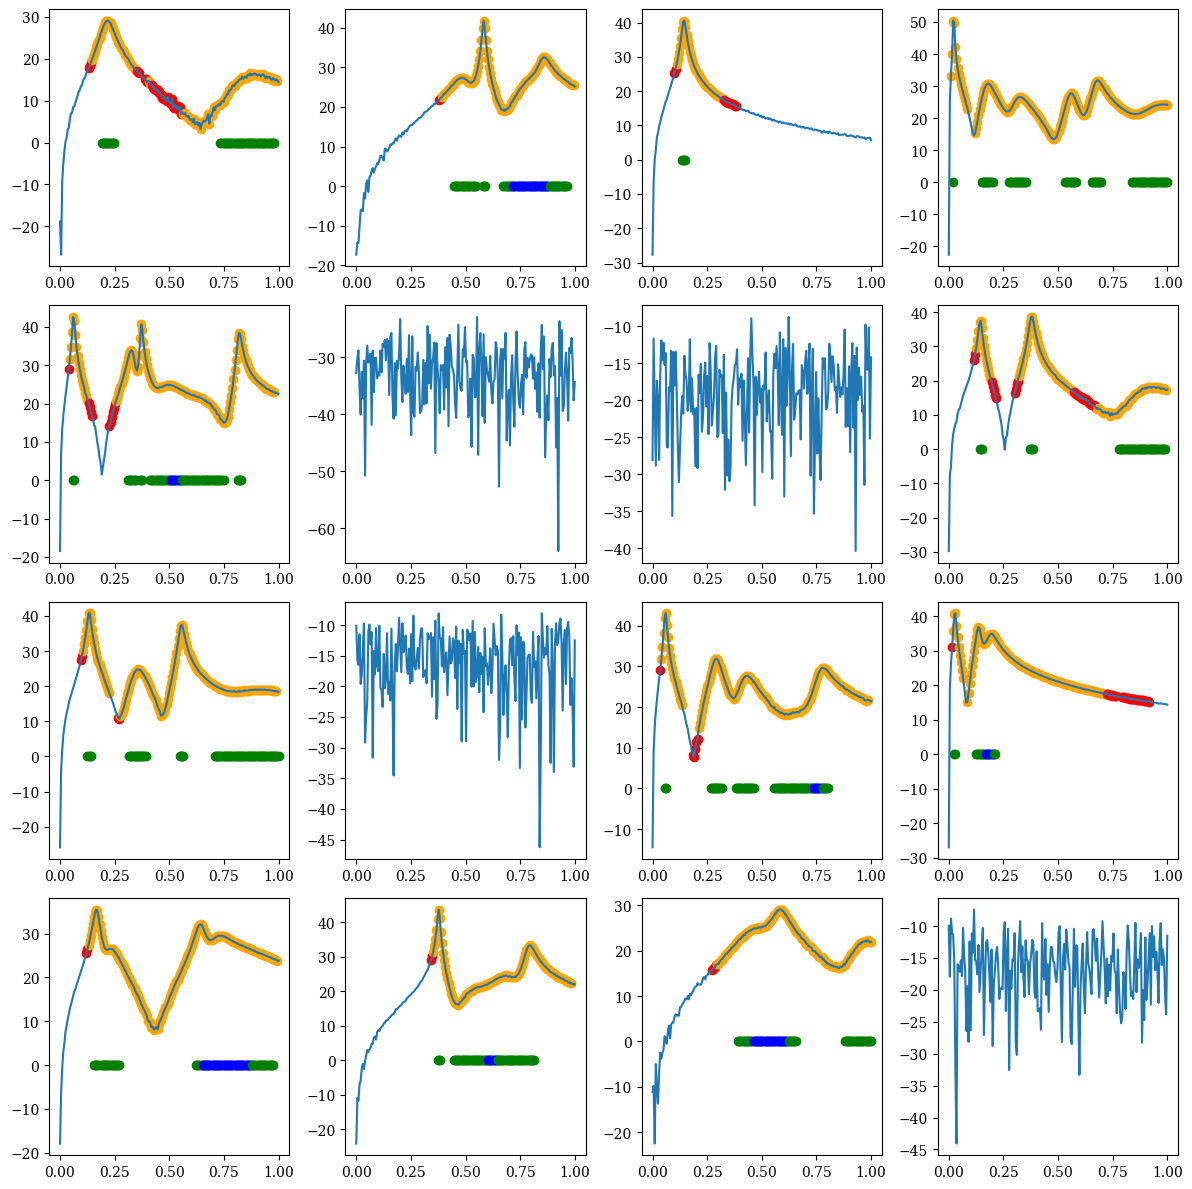

In [387]:
validate_model(multiclass_model_3)

In [425]:
X, y, _, __ = generate_data(32*500,200, multiclass=False)
valX, valy, _, __ = generate_data(32*100, 200, multiclass=False)

vel_binary_model = BiLSTM(input_size, hidden_size, num_layers, num_classes=1)
train_model_binary(vel_binary_model, X, y, valX, valy, 'lstm_velocity_binary', num_epochs=80)

# Epoch [80/80], Loss: 0.374204652428627, Precision: 0.9824351099249526, Recall: 0.6955519434199384
# Validation Precision: 0.9875099912630699, Validation Recall: 0.9904150663780592

Epoch [1/80], Loss: 0.48759313541650773, Precision: 0.8710793415345294, Recall: 0.6696737593117391
Validation Precision: 0.9412982812275934, Validation Recall: 0.9744018800232566
Epoch [2/80], Loss: 0.42492347770929334, Precision: 0.9294947544062886, Recall: 0.6834387839306103
Validation Precision: 0.9563919137254757, Validation Recall: 0.9740232229480007
Epoch [3/80], Loss: 0.41141283011436464, Precision: 0.9424498982042531, Recall: 0.6875806460829738
Validation Precision: 0.9561619598321549, Validation Recall: 0.9827942488945015
Epoch [4/80], Loss: 0.4060258120894432, Precision: 0.9480541367425432, Recall: 0.6881141661622892
Validation Precision: 0.9605285915959033, Validation Recall: 0.9834125885880707
Epoch [5/80], Loss: 0.40149463480710984, Precision: 0.951941563210498, Recall: 0.6905417692314306
Validation Precision: 0.958285334899998, Validation Recall: 0.9850907596129997
Epoch [6/80], Loss: 0.39929297178983686, Precision: 0.9551572158706403, Recall: 0.6897265603267873
Validatio

In [426]:
X = normalise(X)
valX = normalise(valX)

vel_binary_model_norm = BiLSTM(input_size, hidden_size, num_layers, num_classes=1)
train_model_binary(vel_binary_model_norm, X, y, valX, valy, 'lstm_velocity_binary_norm', num_epochs=80)

# Epoch [80/80], Loss: 0.3738855789899826, Precision: 0.9824498872768243, Recall: 0.6963931448911599
# Validation Precision: 0.9816247712679492, Validation Recall: 0.9950063764649637

Epoch [1/80], Loss: 0.5145330127477646, Precision: 0.8593620254938158, Recall: 0.6586012978681322
Validation Precision: 0.956321179265454, Validation Recall: 0.9614801077531492
Epoch [2/80], Loss: 0.42455415898561477, Precision: 0.93171831018252, Recall: 0.6842199429609369
Validation Precision: 0.9359544025461944, Validation Recall: 0.9878583300037944
Epoch [3/80], Loss: 0.41086462152004244, Precision: 0.9451799870749326, Recall: 0.6870262179540985
Validation Precision: 0.9570237177047207, Validation Recall: 0.9855763707652282
Epoch [4/80], Loss: 0.40649227833747864, Precision: 0.9492884217652161, Recall: 0.688042196103464
Validation Precision: 0.9621738977819796, Validation Recall: 0.9849859010754721
Epoch [5/80], Loss: 0.39887688505649566, Precision: 0.9551959085110263, Recall: 0.6911832326616949
Validation Precision: 0.9817628394002798, Validation Recall: 0.9749126321063415
Epoch [6/80], Loss: 0.3970269574522972, Precision: 0.9574801020968584, Recall: 0.6911672284026893
Validation P

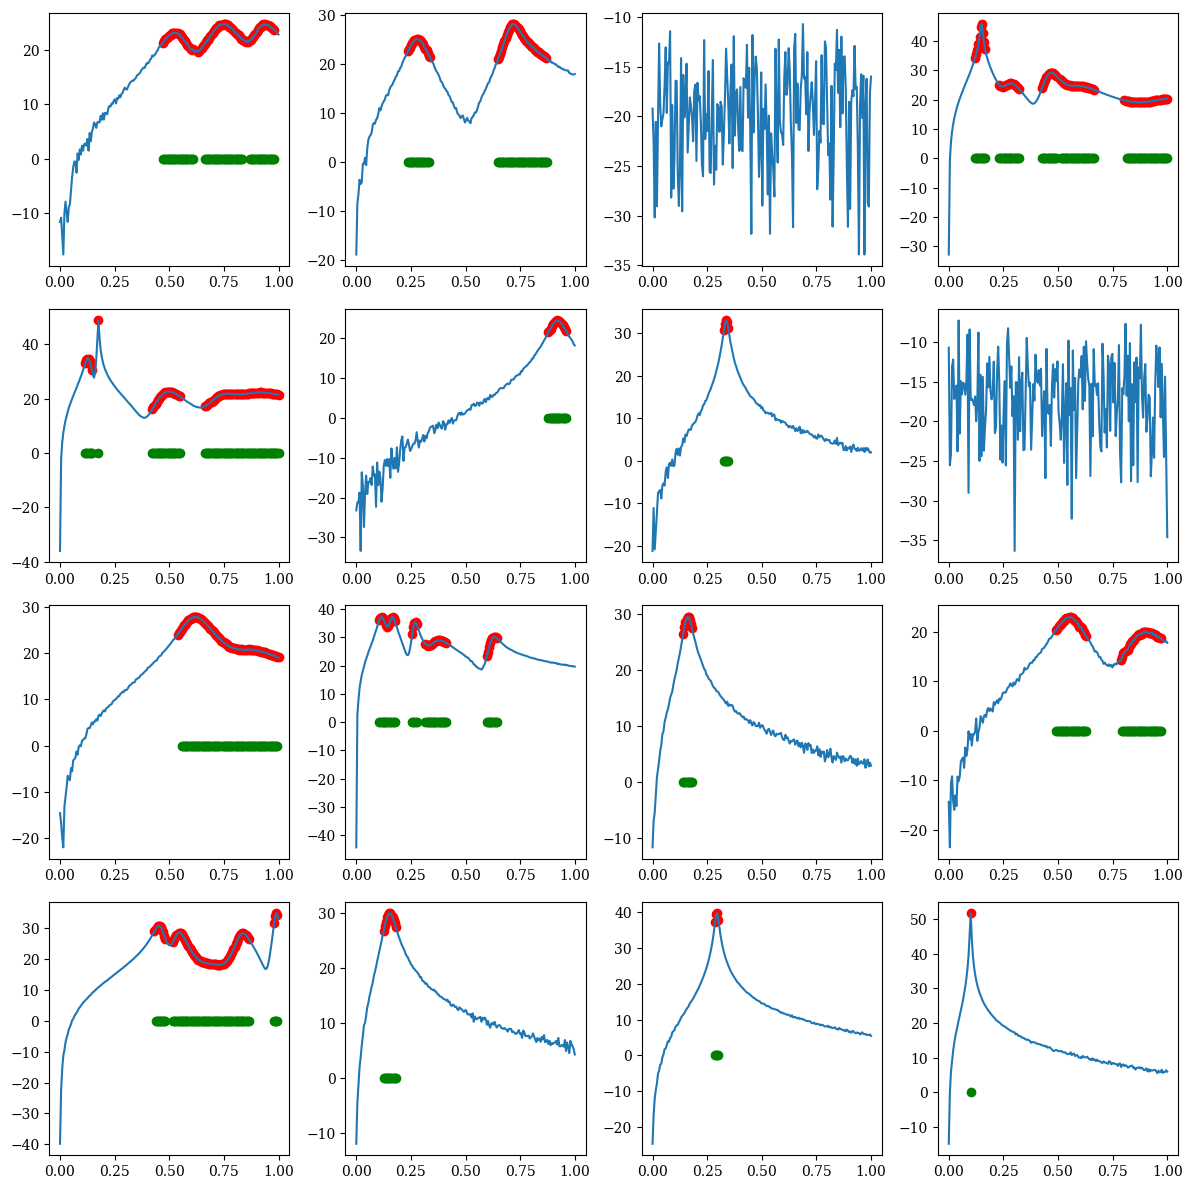

In [431]:
# vel_binary_model = torch.load('lstm_velocity_binary.pth')
validate_model(vel_binary_model, multiclass=False, norm=False)

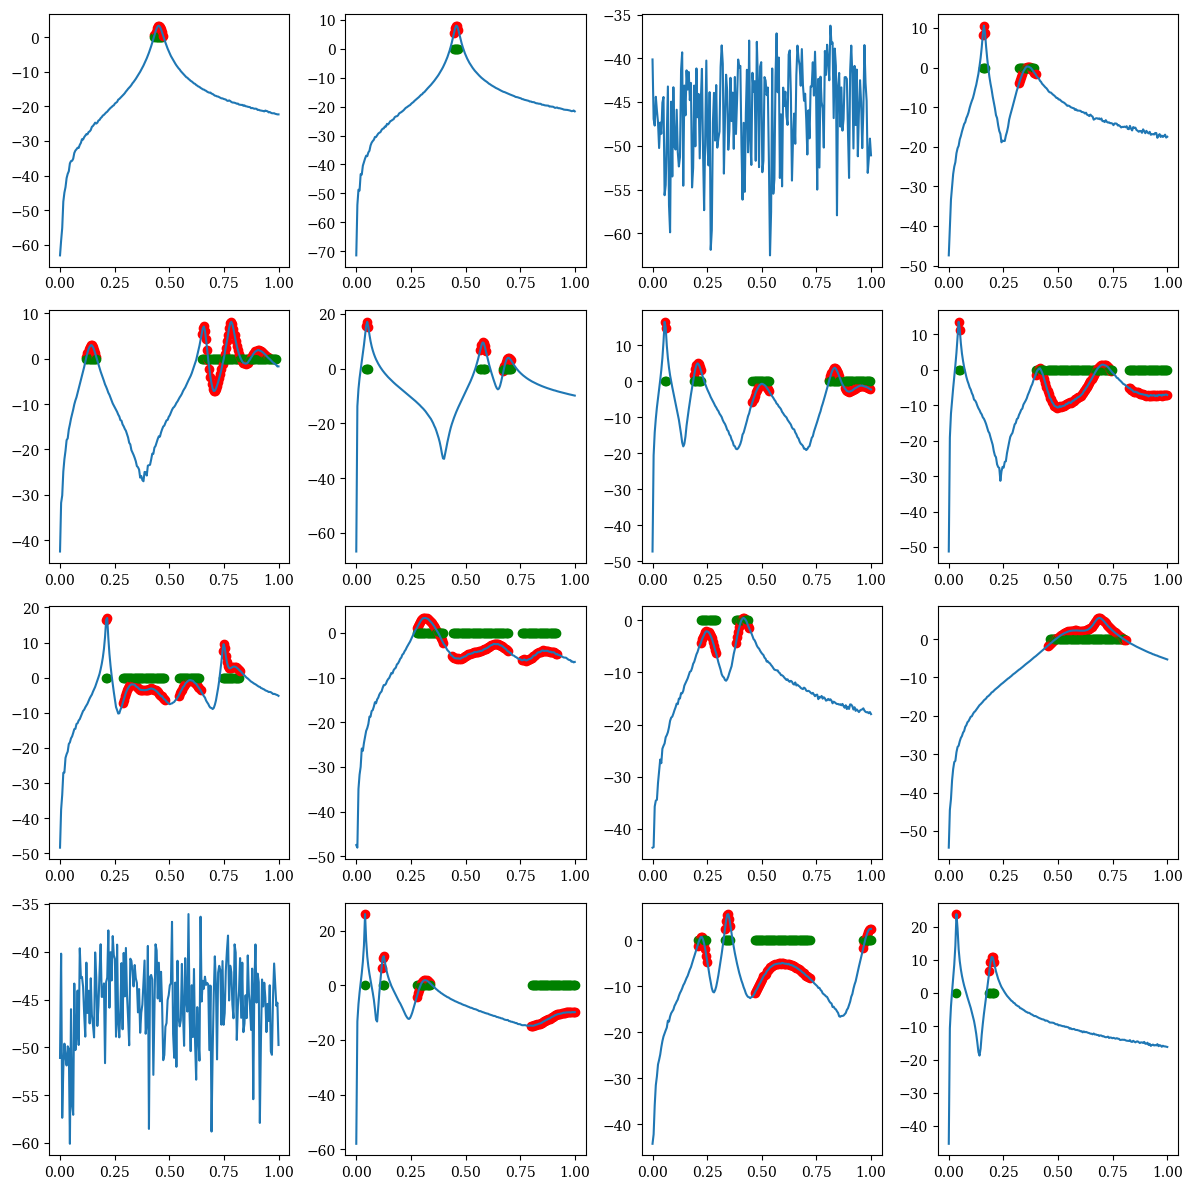

In [433]:
validate_model(vel_binary_model_norm, multiclass=False, norm=True)

In [87]:
d = dvma.load_data()
tf_data = d.tf_data_list[0]
tf_arr = np.array(tf_data.tf_data)
print(tf_arr.shape)

2023-11-18 17:53:37.771 python[72373:5674537] +[CATransaction synchronize] called within transaction
2023-11-18 17:53:37.822 python[72373:5674537] +[CATransaction synchronize] called within transaction


(8183, 1)


In [88]:
def lab_predictions(model, tf_arr, norm=False, multiclass=False):
    lab_tf = split_real_imag(tf_arr).reshape(1, -1, 2)
    if norm:
        lab_tf = normalise(lab_tf)
    lab_tf_tensor = torch.from_numpy(lab_tf).to(torch.float32)

    model.eval()
    with torch.no_grad():
        lab_tf_output = model(lab_tf_tensor)
    
    if multiclass:
        test_op = np.array(lab_tf_output.numpy())
        predictions = np.argmax(test_op, axis=-1).reshape(-1)
    else:
        test_op = lab_tf_output.numpy().reshape(-1)
        predictions = (test_op > 0.0).astype(int)
    
    input_tf = split_real_imag(tf_arr)
    plot_tf(input_tf, predictions)

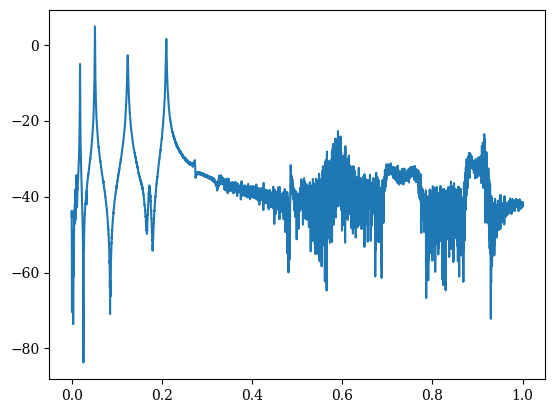

In [89]:
lab_predictions(vel_binary_model, tf_arr, norm=False, multiclass=False)

In [86]:
lab_predictions(vel_binary_model_norm, tf_arr[:3000], norm=True, multiclass=False)

NameError: name 'tf_arr' is not defined

In [84]:
Xnorm, ynorm, _, __ = generate_data(32,200, multiclass=False)

(32, 200, 2)
(200, 2)
(200,)


(<Figure size 640x480 with 1 Axes>, <Axes: >)

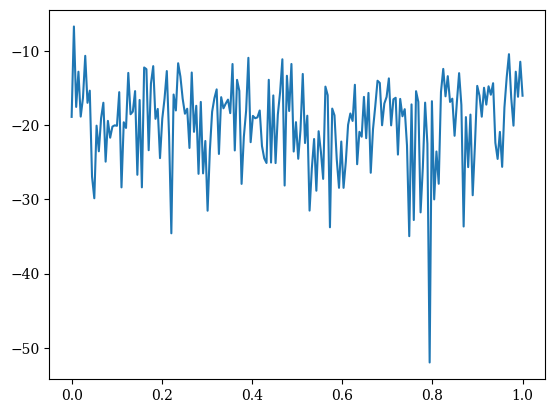

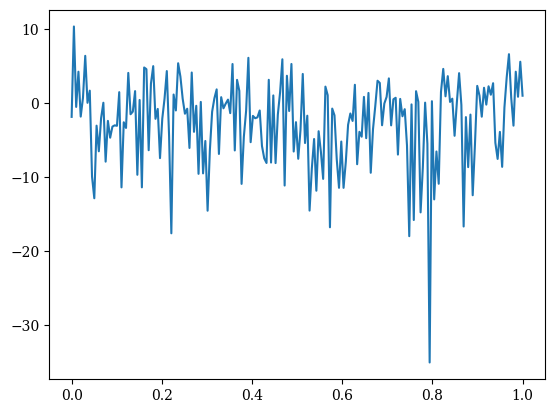

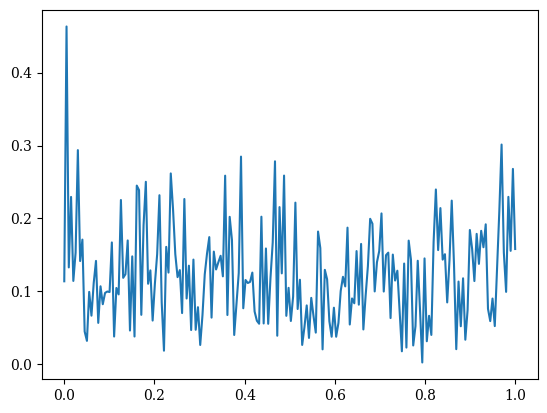

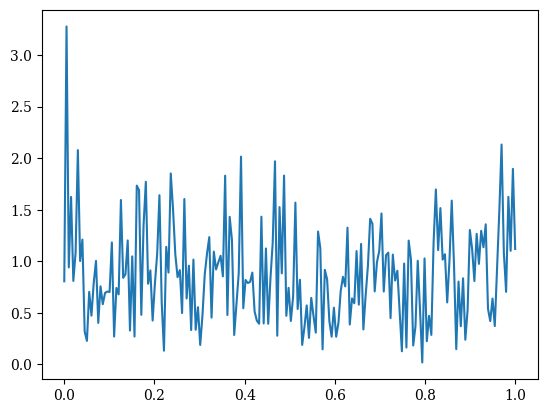

In [85]:
print(Xnorm.shape)
print(Xnorm[0].shape)
print(ynorm[0].shape)
plot_tf(Xnorm[0], ynorm[0])
plot_tf(normalise(Xnorm[0]), ynorm[0])
plot_tf(Xnorm[0], ynorm[0], todb=False)
plot_tf(normalise(Xnorm[0]), ynorm[0], todb=False)

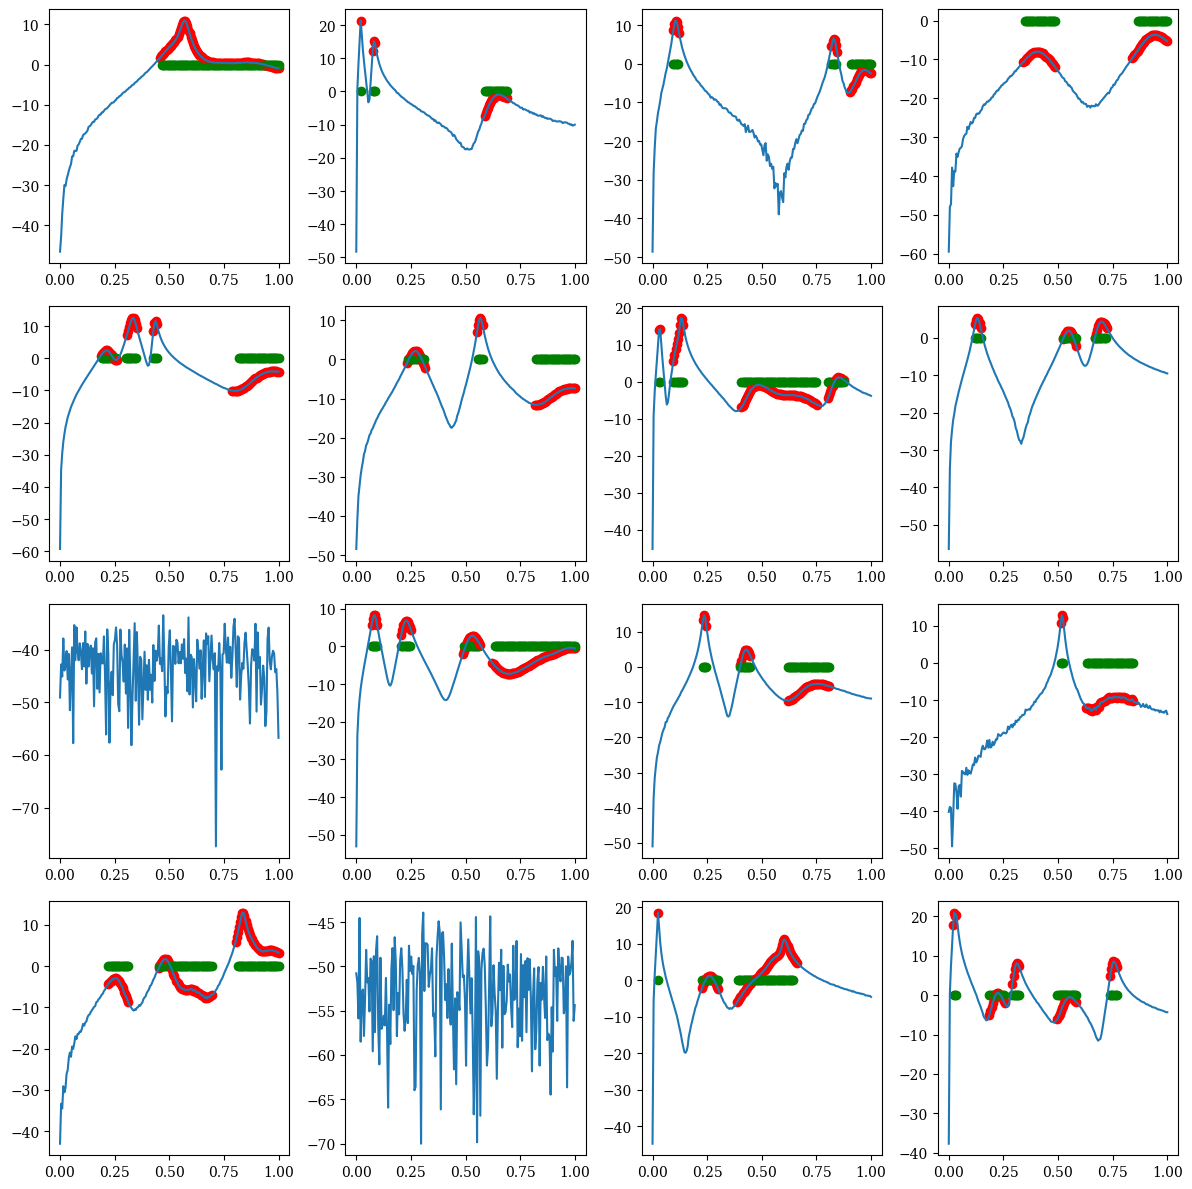

In [65]:
vel_binary_model_norm = torch.load('lstm_velocity_binary_norm.pth')
validate_model(vel_binary_model_norm, multiclass=False, norm=True)